In [12]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, BoundaryNorm
import seaborn as sns
import os
import re
import utils as ut
from utils import get_by_index


def plot(path, params="sample_matrix.csv", model="results.csv", target="targets.csv"):
    df_param = pd.read_csv(os.path.join(path, params))
    df_model = pd.read_csv(os.path.join(path, model))
    target_df = pd.read_csv(os.path.join(path, target), skiprows=[0])
    df_model  = pd.concat([df_model, target_df], ignore_index=True)

    xparams_MD1, ymodel_MD1 =  ut.get_best_match(df_param,df_model)
    rmetric='r2rmse'
    nelem=10
    order=True
    y_sort=ymodel_MD1.sort_values(by=[rmetric],ascending=order).iloc[:nelem,:-6].copy()
    df2 = pd.concat([y_sort, df_model.iloc[-1:]], ignore_index=True)

    error='diff'
    # Define groups for separate normalization
    gpp_cols = [col for col in df_model.columns if 'GPP' in col]
    npp_cols = [col for col in df_model.columns if 'NPP' in col]
    c_leaf_cols = [col for col in df_model.columns if 'VEGC' in col and 'Leaf' in col]
    c_stem_cols = [col for col in df_model.columns if 'VEGC' in col and 'Stem' in col]
    c_root_cols = [col for col in df_model.columns if 'VEGC' in col and 'Root' in col]
    n_leaf_cols = [col for col in df_model.columns if 'VEGN' in col and 'Leaf' in col]
    n_stem_cols = [col for col in df_model.columns if 'VEGN' in col and 'Stem' in col]
    n_root_cols = [col for col in df_model.columns if 'VEGN' in col and 'Root' in col]
    n_soil = [col for col in df_model.columns if col in ['SHLWC', 'DEEPC', 'MINEC', 'AVLN']]

    n_size=len(df2.iloc[:,0])-1
    df_model_normalized = df2.copy() 

    df_model_normalized_gpp = df2[gpp_cols]/ max(df2[gpp_cols].max())

    df_model_normalized_npp = df2[npp_cols]/ max(df2[npp_cols].max())

    c_combined=c_leaf_cols+c_stem_cols+c_root_cols
    df_model_normalized_c_combined = df2[c_combined]/ max(df2[c_combined].max())

    n_combined=n_leaf_cols+n_stem_cols+n_root_cols
    df_model_normalized_n_combined = df2[n_combined]/ max(df2[n_combined].max())

    df_model_normalized_soil = df2[n_soil]/ max(df2[n_soil].max())

    if error=='re':
        rmse_gpp = relative_error(df_model_normalized_gpp.iloc[:n_size],df_model_normalized_gpp.iloc[n_size]) 
        rmse_npp = relative_error(df_model_normalized_npp.iloc[:n_size],df_model_normalized_npp.iloc[n_size]) 
        rmse_c = relative_error(df_model_normalized_c_combined.iloc[:n_size],df_model_normalized_c_combined.iloc[n_size]) 
        rmse_n = relative_error(df_model_normalized_n_combined.iloc[:n_size],df_model_normalized_n_combined.iloc[n_size]) 
        rmse_soil = relative_error(df_model_normalized_soil.iloc[:n_size],df_model_normalized_soil.iloc[n_size]) 
    elif error=='diff':
        rmse_gpp = (df_model_normalized_gpp.iloc[:n_size].mean()-df_model_normalized_gpp.iloc[n_size]).to_frame() 
        rmse_npp = (df_model_normalized_npp.iloc[:n_size].mean()-df_model_normalized_npp.iloc[n_size]).to_frame() 
        rmse_c = (df_model_normalized_c_combined.iloc[:n_size].mean()-df_model_normalized_c_combined.iloc[n_size]).to_frame() 
        rmse_n = (df_model_normalized_n_combined.iloc[:n_size].mean()-df_model_normalized_n_combined.iloc[n_size]).to_frame() 
        rmse_soil = (df_model_normalized_soil.iloc[:n_size].mean()-df_model_normalized_soil.iloc[n_size]).to_frame() 
    else:
        rmse_gpp = rmse(df_model_normalized_gpp.iloc[:n_size],df_model_normalized_gpp.iloc[n_size]) 
        rmse_npp = rmse(df_model_normalized_npp.iloc[:n_size],df_model_normalized_npp.iloc[n_size]) 
        rmse_c = rmse(df_model_normalized_c_combined.iloc[:n_size],df_model_normalized_c_combined.iloc[n_size]) 
        rmse_n = rmse(df_model_normalized_n_combined.iloc[:n_size],df_model_normalized_n_combined.iloc[n_size]) 
        rmse_soil = rmse(df_model_normalized_soil.iloc[:n_size],df_model_normalized_soil.iloc[n_size])

    #build the error matrix
    err_matrix_above = pd.DataFrame({
        'GPP': get_by_index(rmse_gpp, gpp_cols),
        'NPP': get_by_index(rmse_npp, npp_cols),
        '$C_{leaf}$': get_by_index(rmse_c, c_leaf_cols), 
        '$C_{stem}$': get_by_index(rmse_c, c_stem_cols), 
        '$C_{root}$': get_by_index(rmse_c, c_root_cols),
        '$N_{leaf}$': get_by_index(rmse_n, n_leaf_cols), 
        '$N_{stem}$': get_by_index(rmse_n, n_stem_cols), 
        '$N_{root}$': get_by_index(rmse_n, n_root_cols)
            })

    # Extract all pft numbers using regex
    pfts = set()

    for col in df_model.columns:
        match = re.search(r'pft[0-9]+', col)
        if match:
            pfts.add(match.group())

    # Turn into a sorted list
    pft_list = sorted(pfts)
    # print(pft_list)
    err_matrix_above.index=pft_list

    print(type(err_matrix_above))
    print(type(err_matrix_above.T))
    err_matrix_below = pd.DataFrame({
        'Soils': get_by_index(rmse_soil, n_soil)
            })

    err_matrix_below.index=n_soil

    cmap, norm, cbar_label = create_custom_colorbar(error)

    sns.set(font_scale=1.5) 

    fig_combined = plt.figure(figsize=(7, 8))
    gs = fig_combined.add_gridspec(2, 1, height_ratios=[9, 1])
    ax_combined1 = fig_combined.add_subplot(gs[0, 0])
    ax_combined2 = fig_combined.add_subplot(gs[1, 0])

    sns.heatmap(err_matrix_above.T, cmap=cmap, norm=norm, annot=True, fmt=".3f",
                cbar_kws={'label': cbar_label, "orientation": 'horizontal', 'pad': 0.15},
                cbar=False,
                annot_kws={"fontsize":12},
                ax=ax_combined1)
    ax_combined1.set_title("PFT Comparison")

    sns.heatmap(err_matrix_below.T, cmap=cmap, norm=norm, annot=True, fmt=".3f",
                cbar_kws={'label': cbar_label, "orientation": 'horizontal', 'pad': 0.35},
                cbar=False,
                annot_kws={"fontsize":12},
                ax=ax_combined2)
    ax_combined2.set_title("Soil Comparison")

    fig_combined.suptitle(path, fontsize=20, y=0.98, fontweight="bold")
    fig_combined.tight_layout()

    combined_path = os.path.join(path, f"{site}.png")
    fig_combined.savefig(combined_path, dpi=300, bbox_inches='tight')
    
    plt.close("all")
    
    return err_matrix_below, err_matrix_above

ImportError: cannot import name 'get_by_index' from 'utils' (/Users/dteber/Downloads/Figures/utils.py)

In [13]:
def get_by_index(zscore,index_list):
    return pd.Series([zscore[0][iname] for iname in index_list])

def rmse(x,x_true):
    MSE = np.square(np.subtract(x.mean(),x_true)) 
    df_z = pd.DataFrame(np.sqrt(MSE))
    df_z.index = x.columns
    return df_z

def relative_error(x,x_true):
    MAE = np.subtract(x.mean(),x_true)
    df_z = pd.DataFrame(abs(100*MAE/x_true))
    df_z.index = x.columns
    return df_z

def create_custom_colorbar(error_type='rmse'):
    color_levels = [-1.0, -0.6, -0.2, 0.2, 0.6, 1.0]
    colors = ['darkblue', 'lightblue', '#f2f2f2', 'orange', 'red']
    cmap = LinearSegmentedColormap.from_list('custom_discrete', colors, N=len(color_levels) - 1)
    norm = BoundaryNorm(color_levels, cmap.N, clip=True)

    if error_type == 'rmse':
        cbar_label = 'RMSE score'
    elif error_type == 'diff':
        cbar_label = 'Normalized (Mean - Observed)'
    else:
        cbar_label = 'RE score'

    return cmap, norm, cbar_label


TypeError: Image data of dtype object cannot be converted to float

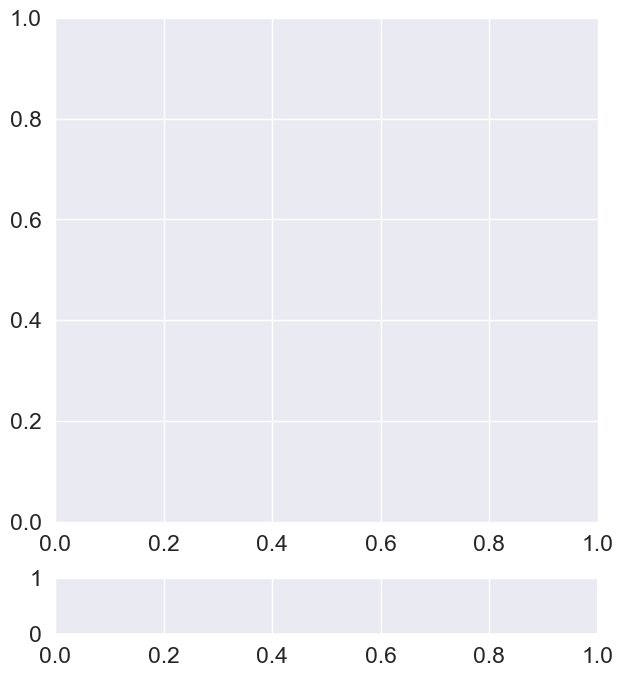

In [14]:
path = "sites/TVC51"

val1, val2 = plot(path)